In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tqdm

In [5]:
train = ['2', '4', '5']
test = ['9_1', '9_2']

In [6]:
data_dir = Path("/home/user1/xakaton2024/data/given_train/")
Y = []
X = []

In [7]:
for img in tqdm.tqdm(train, total=len(train)):
    dataset = rasterio.open(data_dir / 'images' / f'{img}.tif')
    y_dataset = rasterio.open(data_dir / 'masks' /  f'{img}.tif')
    all_data = dataset.read()
    all_true = y_dataset.read()
    all_data.shape, all_true.shape

    # Optimize data extraction for X
    X.extend(all_data.reshape(all_data.shape[0], -1).T.tolist())  # Flatten and transpose


    # Optimize data extraction for Y
    Y.extend(all_true[0].flatten().tolist())

100%|██████████| 3/3 [02:24<00:00, 48.02s/it]


In [44]:
plt.imshow(all_true[0])

In [10]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 21.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)
reg.score(X, Y)


KeyboardInterrupt: 

In [13]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 50.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [44]:
reg.coef_

array([-2.43044733e-04,  4.88576773e-04, -1.64091980e-04,  6.77286919e-05,
       -1.52470301e-05,  2.06289977e-04, -2.48484055e-04, -2.38227972e-04,
       -3.47202779e-05, -2.30404365e-04])

In [14]:
from catboost import CatBoostClassifier , Pool
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)
model = CatBoostClassifier(iterations=20000,
                           learning_rate=0.02,
                           depth=2,
                           custom_metric="F1")
eval_dataset = Pool(data=X_test,
                    label=y_test)
train_dataset = Pool(data=X_train,
                     label=y_train)

model.fit(train_dataset, eval_set=eval_dataset)


In [54]:
print(model.score(X_test, y_test))

ValueError: operands could not be broadcast together with shapes (86508,) (1,512,512) 

In [53]:
import tqdm
test = rasterio.open('9_2.tif')
test = test.read()
y_test = rasterio.open('9_2 (1).tif')
y_test = y_test.read()

mask = np.zeros((1,512,512))
X = []
for i in tqdm.tqdm(range(test.shape[1])):
    for j in range(test.shape[2]):
        tmp = []
        for k in range(test.shape[0]):
            tmp.append(test[k, i, j])

        mask[0, i, j] = model.predict_proba([tmp])[0][0]
        X.append(tmp)
X = np.array(X)
print(X.shape)

Y = []
for i in range(y_test.shape[1]):
    for j in range(y_test.shape[2]):
        Y.append(y_test[0, i, j])
Y = np.array(Y)
print(Y.shape)





100%|██████████| 512/512 [01:37<00:00,  5.25it/s]


(262144, 10)
(262144,)


In [55]:
mask[0]

array([[2.00769513e-02, 3.77803743e-01, 9.64794765e-01, ...,
        3.59668899e-01, 3.11104585e-01, 1.33838050e-01],
       [2.32137628e-02, 8.14559896e-03, 6.46905899e-01, ...,
        3.43404648e-01, 3.05438996e-01, 5.09037582e-02],
       [5.33461760e-01, 8.62330548e-03, 3.49228869e-02, ...,
        4.98758969e-01, 2.29056091e-02, 2.34721264e-02],
       ...,
       [3.66702669e-04, 4.45423514e-04, 4.24346941e-04, ...,
        3.87474087e-04, 3.76383452e-04, 3.87279932e-04],
       [4.47779330e-04, 4.28258100e-04, 3.62965851e-04, ...,
        3.85889008e-04, 3.82136340e-04, 3.58140664e-04],
       [3.79127152e-04, 4.32448789e-04, 5.47702885e-04, ...,
        3.85889008e-04, 3.55245353e-04, 3.70499957e-04]])

In [60]:
np.save('mask.npy', mask[0])

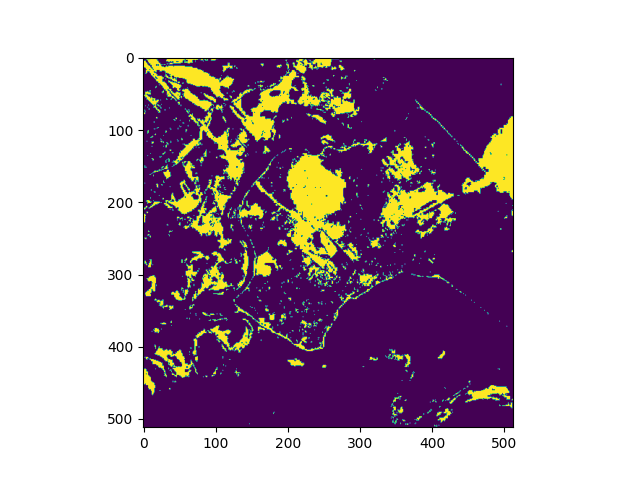

In [61]:
# %matplotlib widget
bin_array = (mask > 0.7).astype(int)
bin_array
np.save('mask.npy', bin_array[0])
plt.imshow(bin_array[0])
plt.show()

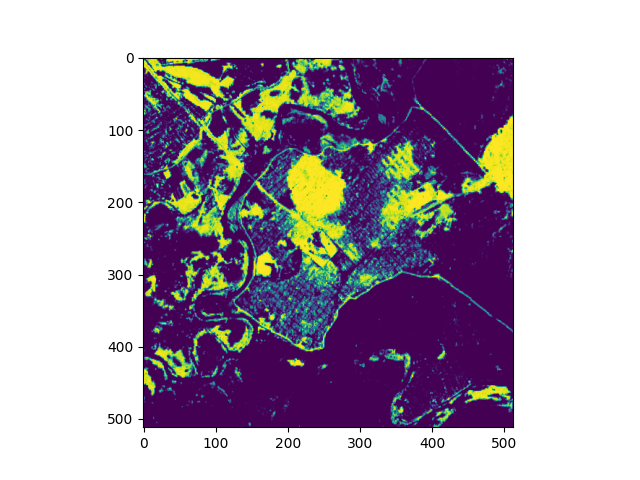

In [57]:
plt.imshow(mask[0])
plt.show()


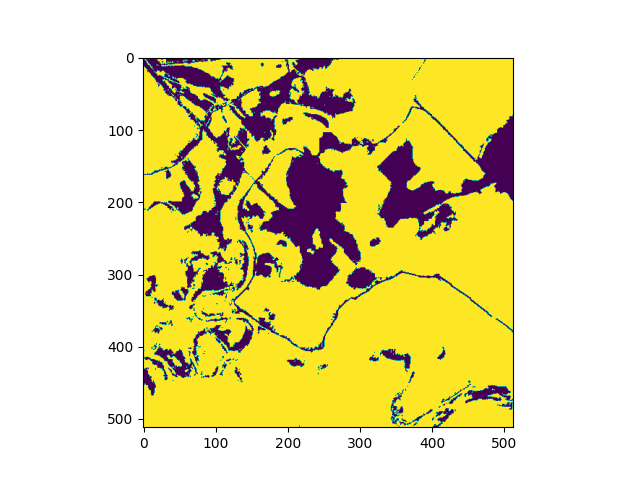

In [58]:
plt.imshow(y_test[0])
plt.show()

In [59]:
model.score(X, Y)

0.9394607543945312